In [1]:
from sklearn.metrics.pairwise import cosine_similarity

import math
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

In [2]:
# 사용자 / 기사 / 단어에 대한 더미 데이터 생성
users = ['user' + str(i) for i in range(1, 1001)]
categories = ['사회', '경제', '정치', '과학', '문화']
articles = [f"{category}기사{i}" for category in categories for i in range(1, 201)]
words = [f"{category}_{i}" for category in categories for i in range(1, 201)]

article_word_df = pd.DataFrame(data = np.zeros((1000, 1000), dtype = int), index = articles, columns = words)
user_word_df = pd.DataFrame(data = np.zeros((1000, 1000), dtype = int), index = users, columns = words)

# 사용자 별로 선호하는 카테고리 설정
user_preferences = [category for category in categories for _ in range(200)]

# 사용자 별 경향성을 반영하여 선호하는 카테고리의 단어를 더 많이 학습
for i, user in enumerate(users):
    preferred_category = user_preferences[i]
    preferred_words = [word for word in words if preferred_category in word]
    non_preferred_words = [word for word in words if preferred_category not in word]

    # 선호하는 카테고리의 단어 중 10~15%를 무작위로 선택하여 학습 횟수를 0으로 설정
    num_to_exclude = int(len(preferred_words) * np.random.uniform(0.1, 0.15))
    excluded_words = np.random.choice(preferred_words, size = num_to_exclude, replace = False)

    for word in preferred_words:
        if word not in excluded_words:
            user_word_df.at[user, word] = np.random.randint(5, 11)
        else:
            user_word_df.at[user, word] = 0

    for word in non_preferred_words:
        user_word_df.at[user, word] = np.random.randint(0, 5)

article_categories = [category for category in categories for _ in range(200)]

# 기사별 카테고리에 따라 TF-IDF 값 조정
for i, article in enumerate(article_word_df.index):
    category = article_categories[i]
    category_words = [word for word in article_word_df.columns if category in word]
    non_category_words = [word for word in article_word_df.columns if category not in word]

    # 해당 카테고리의 단어 중 10~15%를 무작위로 선택하여 TF-IDF 값을 0으로 설정
    num_to_exclude = int(len(category_words) * np.random.uniform(0.1, 0.15))
    excluded_words = np.random.choice(category_words, size = num_to_exclude, replace = False)

    for word in category_words:
        if word not in excluded_words:
            article_word_df.at[article, word] = np.random.uniform(0.5, 1)
        else:
            article_word_df.at[article, word] = 0  # 명시적으로 0으로 설정

    for word in non_category_words:
        article_word_df.at[article, word] = np.random.uniform(0, 0.5)

In [3]:
user_word_df

,사회_1,사회_2,사회_3,사회_4,사회_5,사회_6,사회_7,사회_8,사회_9,사회_10,...,문화_191,문화_192,문화_193,문화_194,문화_195,문화_196,문화_197,문화_198,문화_199,문화_200
user1,5,6,7,8,6,8,9,0,0,8,...,1,0,4,3,4,0,0,0,0,1
user2,5,5,0,5,9,7,9,8,5,8,...,3,0,0,4,4,2,4,1,4,4
user3,5,9,9,5,9,6,10,8,10,7,...,3,1,2,1,3,0,4,1,0,4
user4,7,7,9,7,10,10,6,8,7,6,...,4,3,4,0,4,2,1,0,0,1
user5,0,8,6,9,9,10,9,9,5,10,...,2,0,1,3,1,2,4,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user996,3,2,4,3,0,0,4,2,0,1,...,9,0,9,10,5,0,9,5,6,10
user997,0,3,2,3,3,3,2,4,2,2,...,6,9,10,6,10,8,0,8,6,9
user998,2,0,0,0,2,2,1,4,2,1,...,6,7,7,10,8,5,5,8,7,6
user999,3,3,0,4,2,0,2,3,4,0,...,7,9,9,8,6,8,9,9,8,9


In [4]:
article_word_df

,사회_1,사회_2,사회_3,사회_4,사회_5,사회_6,사회_7,사회_8,사회_9,사회_10,...,문화_191,문화_192,문화_193,문화_194,문화_195,문화_196,문화_197,문화_198,문화_199,문화_200
사회기사1,0.697186,0.679291,0.907788,0.000000,0.505008,0.880760,0.597487,0.755568,0.868614,0.000000,...,0.366535,0.438876,0.148833,0.272221,0.195062,0.043405,0.407761,0.029747,0.136731,0.387921
사회기사2,0.967085,0.637859,0.681313,0.682861,0.857915,0.537739,0.896640,0.560790,0.564141,0.000000,...,0.396002,0.245076,0.173035,0.217005,0.345929,0.066303,0.407583,0.035353,0.426754,0.046318
사회기사3,0.940624,0.510672,0.524312,0.785682,0.852948,0.558788,0.799299,0.696361,0.817181,0.829392,...,0.474367,0.335107,0.161413,0.159389,0.077480,0.400689,0.413308,0.173843,0.449285,0.207490
사회기사4,0.641004,0.605004,0.939165,0.727697,0.996721,0.660294,0.951560,0.504158,0.000000,0.818732,...,0.218078,0.408880,0.487954,0.146345,0.295153,0.243086,0.048282,0.002147,0.475221,0.179000
사회기사5,0.513977,0.000000,0.000000,0.768404,0.000000,0.729556,0.904640,0.883363,0.701275,0.679330,...,0.103425,0.294852,0.383319,0.248216,0.154754,0.043624,0.415106,0.325603,0.154664,0.306500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
문화기사196,0.481093,0.215184,0.200226,0.032087,0.113093,0.291167,0.358326,0.203180,0.184462,0.187693,...,0.911983,0.638856,0.827669,0.894978,0.737150,0.978171,0.742643,0.650408,0.812597,0.974769
문화기사197,0.399849,0.447626,0.052266,0.312810,0.336233,0.221041,0.482105,0.334366,0.233813,0.218052,...,0.522689,0.510099,0.832363,0.000000,0.000000,0.670029,0.850430,0.000000,0.580667,0.572493
문화기사198,0.337641,0.028247,0.294908,0.294157,0.253191,0.192531,0.026430,0.094562,0.098538,0.174941,...,0.749193,0.633635,0.687014,0.803816,0.531829,0.962524,0.959979,0.947294,0.667318,0.604303
문화기사199,0.408972,0.217508,0.488631,0.254644,0.219252,0.044457,0.080588,0.218764,0.304269,0.386413,...,0.925399,0.920074,0.915364,0.856643,0.963193,0.000000,0.755191,0.000000,0.622096,0.917104


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/p

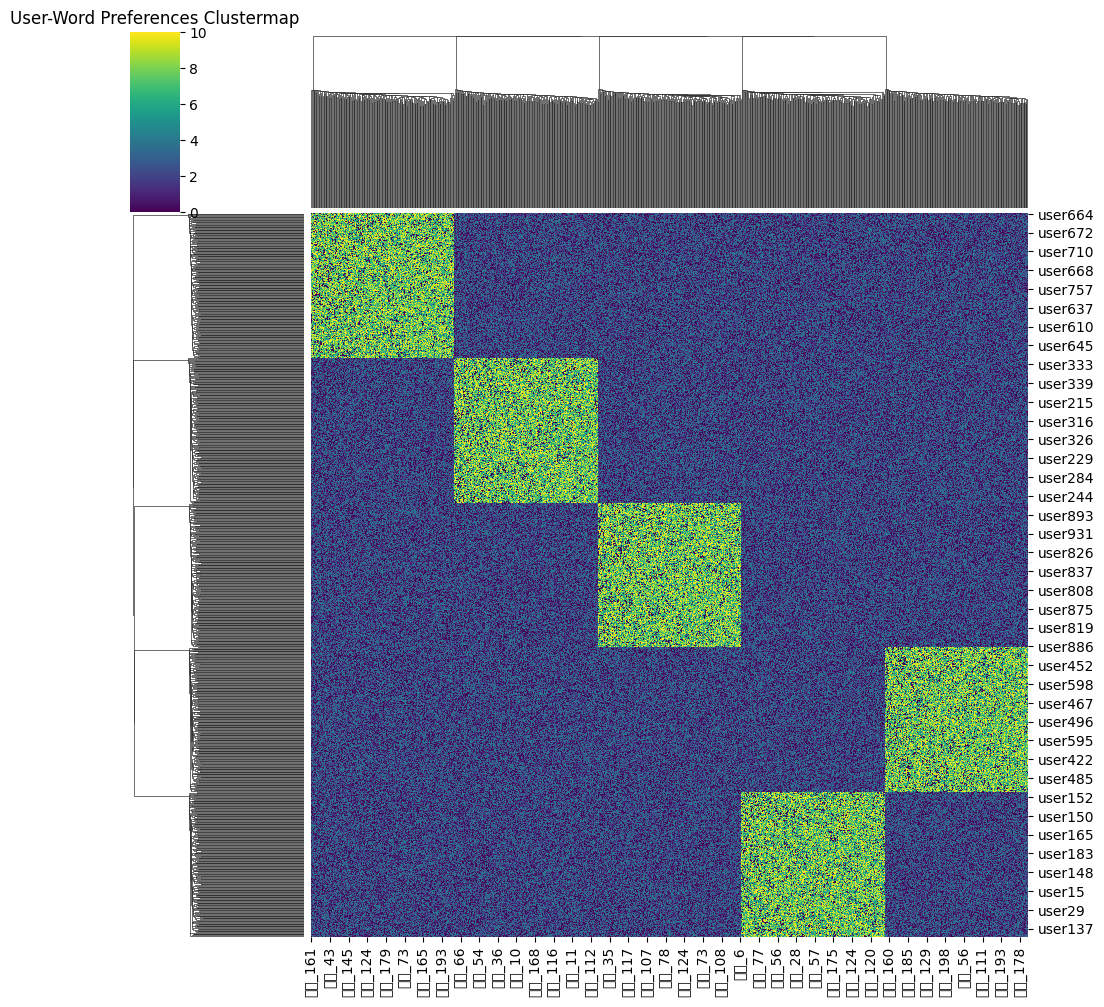

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


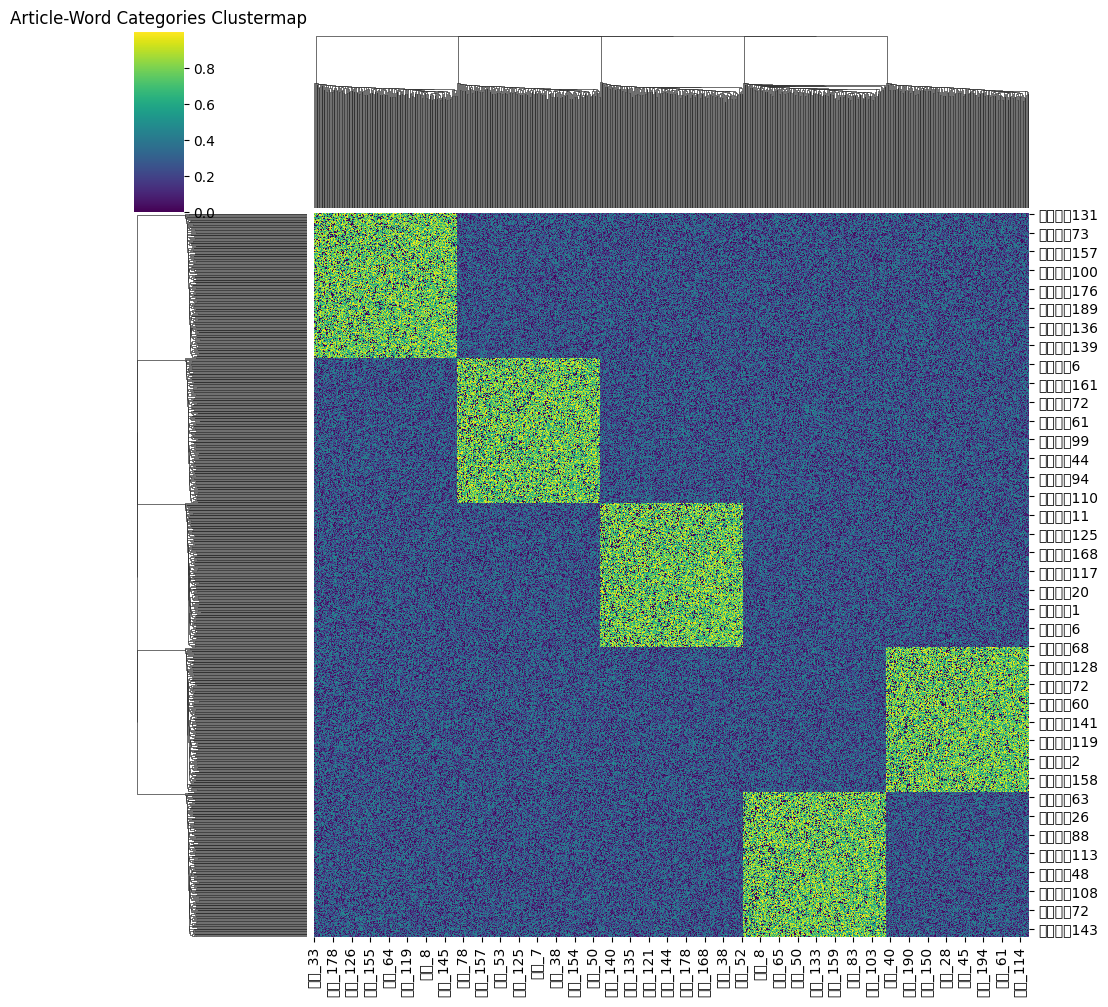

In [5]:
plt.rcParams['figure.figsize'] = (10, 8)  # 시각화 크기 설정
plt.rcParams['figure.dpi'] = 100  # 해상도 설정

# user_word_df 데이터프레임에 대한 Clustermap 생성
sns.clustermap(user_word_df, method = 'average', metric = 'euclidean', figsize = (10, 10), cmap = 'viridis')
plt.title("User-Word Preferences Clustermap")
plt.show()

# article_word_df 데이터프레임에 대한 Clustermap 생성
sns.clustermap(article_word_df, method = 'average', metric = 'euclidean', figsize = (10, 10), cmap = 'viridis')
plt.title("Article-Word Categories Clustermap")
plt.show()

In [6]:
# 데이터 간 Scale을 맞추기 위하여 Min-Max 정규화
user_word_df_norm = (user_word_df - user_word_df.min()) / (user_word_df.max() - user_word_df.min())
user_word_df_norm

,사회_1,사회_2,사회_3,사회_4,사회_5,사회_6,사회_7,사회_8,사회_9,사회_10,...,문화_191,문화_192,문화_193,문화_194,문화_195,문화_196,문화_197,문화_198,문화_199,문화_200
user1,0.5,0.6,0.7,0.8,0.6,0.8,0.9,0.0,0.0,0.8,...,0.1,0.0,0.4,0.3,0.4,0.0,0.0,0.0,0.0,0.1
user2,0.5,0.5,0.0,0.5,0.9,0.7,0.9,0.8,0.5,0.8,...,0.3,0.0,0.0,0.4,0.4,0.2,0.4,0.1,0.4,0.4
user3,0.5,0.9,0.9,0.5,0.9,0.6,1.0,0.8,1.0,0.7,...,0.3,0.1,0.2,0.1,0.3,0.0,0.4,0.1,0.0,0.4
user4,0.7,0.7,0.9,0.7,1.0,1.0,0.6,0.8,0.7,0.6,...,0.4,0.3,0.4,0.0,0.4,0.2,0.1,0.0,0.0,0.1
user5,0.0,0.8,0.6,0.9,0.9,1.0,0.9,0.9,0.5,1.0,...,0.2,0.0,0.1,0.3,0.1,0.2,0.4,0.0,0.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user996,0.3,0.2,0.4,0.3,0.0,0.0,0.4,0.2,0.0,0.1,...,0.9,0.0,0.9,1.0,0.5,0.0,0.9,0.5,0.6,1.0
user997,0.0,0.3,0.2,0.3,0.3,0.3,0.2,0.4,0.2,0.2,...,0.6,0.9,1.0,0.6,1.0,0.8,0.0,0.8,0.6,0.9
user998,0.2,0.0,0.0,0.0,0.2,0.2,0.1,0.4,0.2,0.1,...,0.6,0.7,0.7,1.0,0.8,0.5,0.5,0.8,0.7,0.6
user999,0.3,0.3,0.0,0.4,0.2,0.0,0.2,0.3,0.4,0.0,...,0.7,0.9,0.9,0.8,0.6,0.8,0.9,0.9,0.8,0.9


In [7]:
# 뉴스 기사 추천 : Cosine 유사도 기반 Content-Based Filtering Algorithm
# 코사인 유사도 기반으로 사용자와 관련성이 높은 기사를 추천하는 방법

# 사용자 - 기사 간 코사인 유사도 계산
cosine_sim = cosine_similarity(user_word_df_norm, article_word_df)

# 코사인 유사도를 DataFrame으로 변환
cosine_sim_df = pd.DataFrame(cosine_sim, columns = articles, index = users)
cosine_sim_df

,사회기사1,사회기사2,사회기사3,사회기사4,사회기사5,사회기사6,사회기사7,사회기사8,사회기사9,사회기사10,...,문화기사191,문화기사192,문화기사193,문화기사194,문화기사195,문화기사196,문화기사197,문화기사198,문화기사199,문화기사200
user1,0.785469,0.798210,0.780511,0.804138,0.787704,0.788184,0.776366,0.789384,0.789529,0.781031,...,0.556543,0.564516,0.548755,0.563286,0.540901,0.560724,0.574902,0.540562,0.570455,0.567266
user2,0.776174,0.795855,0.788574,0.791669,0.806401,0.773538,0.793823,0.800118,0.796847,0.793309,...,0.550412,0.569620,0.542674,0.557289,0.550225,0.552363,0.563043,0.555559,0.545284,0.565538
user3,0.785796,0.803761,0.787778,0.790607,0.795354,0.774830,0.776319,0.809449,0.802997,0.799478,...,0.563362,0.566052,0.551043,0.544230,0.551712,0.561639,0.566569,0.564663,0.553536,0.586724
user4,0.800421,0.796841,0.783359,0.786802,0.785529,0.782004,0.776705,0.794458,0.801995,0.786752,...,0.556911,0.581265,0.554064,0.553520,0.549679,0.568390,0.573128,0.558697,0.571838,0.578892
user5,0.789237,0.800683,0.792323,0.789645,0.804494,0.781261,0.789834,0.804571,0.798109,0.795162,...,0.550891,0.567880,0.552821,0.546811,0.548552,0.550254,0.557173,0.550331,0.547621,0.579064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user996,0.567882,0.569452,0.561742,0.576151,0.546649,0.559285,0.556747,0.562939,0.564326,0.541776,...,0.793707,0.795181,0.806073,0.789098,0.800652,0.801645,0.801298,0.783164,0.794753,0.796067
user997,0.560499,0.550301,0.555436,0.552351,0.533312,0.553129,0.543237,0.560078,0.555738,0.546179,...,0.783280,0.789608,0.793313,0.773951,0.805839,0.793418,0.784177,0.774319,0.795054,0.795628
user998,0.564950,0.560574,0.551809,0.550629,0.553968,0.557063,0.547808,0.560892,0.557864,0.543094,...,0.769738,0.783653,0.799874,0.775448,0.785099,0.785581,0.778514,0.777756,0.780502,0.801398
user999,0.564604,0.554304,0.554165,0.554028,0.544393,0.572373,0.548465,0.549288,0.564114,0.547921,...,0.789092,0.785130,0.811081,0.804302,0.808863,0.805970,0.800401,0.788170,0.801859,0.801707


In [8]:
# 각 사용자에 대한 추천 리스트 생성하여 추천 점수가 높은 기사 추천

# 실제로 구현할 때는 해당 기사가 이미 읽었던 기사인지, 아닌지 검증하는 과정 추가 필요

recommendations = {}
for user in users:
    user_data = cosine_sim_df.loc[user].sort_values(ascending = False)
    recommendations[user] = user_data.index.values.tolist()[:3]

print(recommendations)

{'user1': ['사회기사76', '사회기사73', '사회기사39'], 'user2': ['사회기사197', '사회기사132', '사회기사172'], 'user3': ['사회기사133', '사회기사15', '사회기사49'], 'user4': ['사회기사131', '사회기사49', '사회기사75'], 'user5': ['사회기사99', '사회기사68', '사회기사172'], 'user6': ['사회기사15', '사회기사13', '사회기사39'], 'user7': ['사회기사139', '사회기사101', '사회기사144'], 'user8': ['사회기사192', '사회기사95', '사회기사16'], 'user9': ['사회기사153', '사회기사190', '사회기사31'], 'user10': ['사회기사165', '사회기사51', '사회기사85'], 'user11': ['사회기사164', '사회기사178', '사회기사141'], 'user12': ['사회기사12', '사회기사196', '사회기사142'], 'user13': ['사회기사160', '사회기사148', '사회기사162'], 'user14': ['사회기사75', '사회기사141', '사회기사110'], 'user15': ['사회기사85', '사회기사187', '사회기사55'], 'user16': ['사회기사51', '사회기사121', '사회기사28'], 'user17': ['사회기사104', '사회기사133', '사회기사73'], 'user18': ['사회기사197', '사회기사172', '사회기사32'], 'user19': ['사회기사143', '사회기사31', '사회기사139'], 'user20': ['사회기사99', '사회기사15', '사회기사65'], 'user21': ['사회기사49', '사회기사143', '사회기사172'], 'user22': ['사회기사55', '사회기사160', '사회기사41'], 'user23': ['사회기사28', '사회기사5', '사회기사65'], 'user24':

In [9]:
# 단어 추천 방법 1 : 해당 사용자가 아직 학습하지 않은 단어들 중 해당 사용자와 유사한 사용자들이 많이 학습한 단어를 추천하는 알고리즘

# 사용자 간 유사도 계산
user_similarity = cosine_similarity(user_word_df_norm)

# 유사도를 DataFrame으로 변환
user_similarity_df = pd.DataFrame(user_similarity, index = users, columns = users)
user_similarity_df

,user1,user2,user3,user4,user5,user6,user7,user8,user9,user10,...,user991,user992,user993,user994,user995,user996,user997,user998,user999,user1000
user1,1.000000,0.789712,0.770230,0.777495,0.791258,0.771855,0.787722,0.784866,0.760344,0.774217,...,0.503302,0.513291,0.508122,0.505847,0.485539,0.516774,0.508675,0.491905,0.501393,0.502288
user2,0.789712,1.000000,0.781064,0.778073,0.785556,0.775253,0.801503,0.766129,0.784963,0.781905,...,0.496638,0.512355,0.510372,0.524471,0.478804,0.508863,0.496524,0.508737,0.504289,0.486553
user3,0.770230,0.781064,1.000000,0.791387,0.781716,0.781529,0.789878,0.781504,0.786717,0.787529,...,0.510370,0.512613,0.521028,0.513974,0.495795,0.517756,0.502200,0.512174,0.512316,0.512562
user4,0.777495,0.778073,0.791387,1.000000,0.780425,0.779622,0.779325,0.753944,0.781288,0.786435,...,0.517617,0.512780,0.519327,0.527829,0.494733,0.515031,0.501522,0.516192,0.515218,0.515582
user5,0.791258,0.785556,0.781716,0.780425,1.000000,0.774103,0.778505,0.771323,0.797505,0.778505,...,0.499175,0.511924,0.499878,0.512110,0.496752,0.498724,0.501684,0.501178,0.501668,0.502111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user996,0.516774,0.508863,0.517756,0.515031,0.498724,0.509997,0.509332,0.516447,0.509526,0.507985,...,0.785260,0.780899,0.793758,0.799592,0.783288,1.000000,0.785011,0.783229,0.797523,0.789431
user997,0.508675,0.496524,0.502200,0.501522,0.501684,0.491280,0.497313,0.492346,0.496200,0.512176,...,0.779024,0.787475,0.801467,0.782612,0.774295,0.785011,1.000000,0.772033,0.785515,0.781924
user998,0.491905,0.508737,0.512174,0.516192,0.501178,0.501955,0.507790,0.517460,0.507044,0.527666,...,0.769412,0.770937,0.792330,0.778686,0.780274,0.783229,0.772033,1.000000,0.785096,0.766400
user999,0.501393,0.504289,0.512316,0.515218,0.501668,0.489407,0.503788,0.509707,0.505771,0.513129,...,0.777533,0.787190,0.802475,0.789820,0.790507,0.797523,0.785515,0.785096,1.000000,0.774342


In [10]:
# 사용자가 아직 학습하지 않은 단어 찾기
unlearned_words = user_word_df_norm.apply(lambda x: x == 0)

# 추천 단어 리스트 생성
word_recommendations = {}
for user in users:
    # 사용자와 유사한 사용자들 찾기
    similar_users = user_similarity_df[user].sort_values(ascending=False).index[1:]

    # 유사한 사용자들이 많이 학습한 단어 찾기
    similar_users_words = user_word_df_norm.loc[similar_users].mean().sort_values(ascending=False)

    # 사용자가 아직 학습하지 않은 단어 중에서 유사한 사용자들이 많이 학습한 단어 선택
    user_unlearned_words = unlearned_words.loc[user]
    recommended_words = similar_users_words[user_unlearned_words].sort_values(ascending=False)

    # 상위 3개 단어 추천
    word_recommendations[user] = recommended_words.index[:3].tolist()

In [11]:
print(word_recommendations)

{'user1': ['과학_26', '정치_109', '과학_163'], 'user2': ['정치_48', '경제_68', '사회_46'], 'user3': ['과학_26', '과학_129', '과학_82'], 'user4': ['정치_109', '과학_114', '정치_106'], 'user5': ['정치_118', '정치_48', '과학_163'], 'user6': ['과학_130', '과학_26', '과학_129'], 'user7': ['문화_174', '경제_175', '정치_10'], 'user8': ['문화_40', '정치_106', '문화_84'], 'user9': ['경제_52', '문화_131', '사회_111'], 'user10': ['과학_130', '문화_131', '정치_106'], 'user11': ['과학_129', '정치_48', '과학_163'], 'user12': ['정치_109', '과학_82', '문화_131'], 'user13': ['과학_82', '정치_48', '정치_17'], 'user14': ['문화_131', '정치_70', '정치_106'], 'user15': ['과학_129', '정치_48', '과학_163'], 'user16': ['정치_109', '문화_174', '과학_114'], 'user17': ['정치_70', '정치_106', '경제_44'], 'user18': ['과학_130', '과학_82', '정치_48'], 'user19': ['과학_82', '과학_114', '문화_84'], 'user20': ['과학_130', '문화_104', '경제_175'], 'user21': ['과학_130', '과학_26', '과학_82'], 'user22': ['정치_118', '정치_109', '과학_163'], 'user23': ['정치_109', '정치_48', '문화_40'], 'user24': ['정치_118', '과학_82', '문화_131'], 'user25': ['과학_26', '정치_109', 

In [12]:
# 단어 추천 방법 2 : Matrix Factorization
# 행렬을 두 개의 저차원 행렬로 분해하여 각각 사용자와 단어의 잠재적 특성을 나타냄
# 잠재적 특성을 기반으로 사용자와 단어 사이의 관계를 예측

# 행렬 분해 모델 클래스 정의
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, latent_dim, dropout_rate=0.8, l2=0.01):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(num_users, latent_dim)
        self.item_embedding = nn.Embedding(num_items, latent_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.l2 = l2

        nn.init.normal_(self.user_embedding.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.item_embedding.weight, mean=0.0, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_indices, item_indices):
        user_latent = self.dropout(self.user_embedding(user_indices))
        item_latent = self.dropout(self.item_embedding(item_indices))
        user_bias = self.user_bias(user_indices).squeeze()
        item_bias = self.item_bias(item_indices).squeeze()

        prediction = torch.sum(user_latent * item_latent, dim=1) + user_bias + item_bias
        return prediction

    def loss(self, prediction, target):
        return F.mse_loss(prediction, target)

# 데이터셋 클래스 정의
class UserWordDataset(Dataset):
    def __init__(self, data):
        self.users = {user: idx for idx, user in enumerate(data.index)}
        self.items = {item: idx for idx, item in enumerate(data.columns)}
        self.ratings = data.values.flatten().astype(np.float32)

        user_indices = [self.users[user] for user in data.index.repeat(len(data.columns))]
        item_indices = [self.items[item] for item in np.tile(data.columns, len(data.index))]

        self.user_indices = np.array(user_indices)
        self.item_indices = np.array(item_indices)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        user = torch.tensor(self.user_indices[idx], dtype=torch.long)
        item = torch.tensor(self.item_indices[idx], dtype=torch.long)
        rating = torch.tensor(self.ratings[idx], dtype=torch.float)
        return user, item, rating

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# RMSE 계산 함수
def compute_rmse(predictions, ratings):
    return torch.sqrt(torch.mean((predictions - ratings) ** 2))

# 데이터 로딩
dataset = UserWordDataset(user_word_df)  # 데이터셋을 디바이스로 옮김
train_size = int(0.8 * len(dataset))
test_valid_size = len(dataset) - train_size
valid_size = test_valid_size // 2
test_size = valid_size

# 데이터셋 분할
train_dataset, test_valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_valid_size])
test_dataset, valid_dataset = torch.utils.data.random_split(test_valid_dataset, [test_size, valid_size])

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

# 모델 초기화
num_users, num_items = len(user_word_df.index), len(user_word_df.columns)
model = MatrixFactorization(num_users, num_items, latent_dim = 270, dropout_rate = 0.8).to(device)

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr =  0.0008)

train_losses_epochs = []
val_losses_epochs = []
val_rmses_epochs = []

# 학습 진행
best_val_loss = float('inf')
for epoch in range(20):
    model.train()
    train_losses = []
    for user_indices, item_indices, ratings in train_loader:
        user_indices, item_indices, ratings = user_indices.to(device), item_indices.to(device), ratings.to(device)
        prediction = model(user_indices, item_indices)
        loss = model.loss(prediction, ratings)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    print(f"Epoch {epoch+1} Training Loss: {avg_train_loss}")

    # 검증 손실 계산
    model.eval()
    total_loss = 0
    total_rmse = 0
    with torch.no_grad():
        for user_indices, item_indices, ratings in valid_loader:
            user_indices, item_indices, ratings = user_indices.to(device), item_indices.to(device), ratings.to(device)
            prediction = model(user_indices, item_indices)
            loss = model.loss(prediction, ratings)
            rmse = compute_rmse(prediction, ratings)

            total_loss += loss.item()
            total_rmse += rmse.item()

    avg_val_loss = total_loss / len(valid_loader)
    avg_val_rmse = total_rmse / len(valid_loader)
    train_losses_epochs.append(avg_train_loss)
    val_losses_epochs.append(avg_val_loss)
    val_rmses_epochs.append(avg_val_rmse)
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss}, RMSE: {avg_val_rmse}")

    # 모델 저장
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_content = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
        }
        torch.save(save_content, 'best_model.pth')

# 테스트 데이터셋을 사용한 모델 평가
model.eval()
total_test_loss = 0
total_test_rmse = 0
with torch.no_grad():
    for user_indices, item_indices, ratings in test_loader:
        user_indices, item_indices, ratings = user_indices.to(device), item_indices.to(device), ratings.to(device)
        prediction = model(user_indices, item_indices)
        loss = model.loss(prediction, ratings)
        rmse = compute_rmse(prediction, ratings)

        total_test_loss += loss.item()
        total_test_rmse += rmse.item()
avg_test_loss = total_test_loss / len(test_loader)
avg_test_rmse = total_test_rmse / len(test_loader)
print(f"Final Test Loss: {avg_test_loss}, RMSE: {avg_test_rmse}")

Epoch 1 Training Loss: 9.451820201835632
Epoch 1 Validation Loss: 6.955865593194504, RMSE: 2.6198798221269635
Epoch 2 Training Loss: 6.8923814894104005
Epoch 2 Validation Loss: 6.550902517651871, RMSE: 2.54526423744414
Epoch 3 Training Loss: 6.524305265235901
Epoch 3 Validation Loss: 5.73236852079649, RMSE: 2.3823536006746884
Epoch 4 Training Loss: 5.783012724761963
Epoch 4 Validation Loss: 4.547160807741962, RMSE: 2.1230408296475254
Epoch 5 Training Loss: 5.273370069160461
Epoch 5 Validation Loss: 3.9917559782358905, RMSE: 1.9892679775516269
Epoch 6 Training Loss: 5.121695918483734
Epoch 6 Validation Loss: 3.8399369779948005, RMSE: 1.9508937043557926
Epoch 7 Training Loss: 5.055077704410553
Epoch 7 Validation Loss: 3.7899268964735726, RMSE: 1.938019799865825
Epoch 8 Training Loss: 5.025107576656342
Epoch 8 Validation Loss: 3.7760565942933906, RMSE: 1.9344127548862098
Epoch 9 Training Loss: 5.001046057605744
Epoch 9 Validation Loss: 3.7653283020356336, RMSE: 1.9315810353040543
Epoch 10

In [14]:
for user_index in range(num_users):
    untrained_item_indices = []
    untrained_item_names = user_word_df.iloc[user_index][user_word_df.iloc[user_index] == 0].index.tolist()
    for item_name in untrained_item_names:
        item_index = dataset.items[item_name]
        untrained_item_indices.append(item_index)

    untrained_item_indices_tensor = torch.tensor(untrained_item_indices, dtype=torch.long, device=device)
    # 예측을 수행
    predictions = model(torch.tensor([user_index] * len(untrained_item_indices), device=device), untrained_item_indices_tensor)
    # 가장 높은 예측 점수를 가진 아이템 인덱스를 추천
    recommended_item_index = untrained_item_indices[torch.argmax(predictions).item()]
    # 추천된 아이템 인덱스를 다시 아이템 이름으로 변환하여 출력
    recommended_item_name = list(dataset.items.keys())[list(dataset.items.values()).index(recommended_item_index)]
    print(f"User {user_index} recommended item: {recommended_item_name}")

User 0 recommended item: 사회_8
User 1 recommended item: 사회_84
User 2 recommended item: 사회_27
User 3 recommended item: 사회_63
User 4 recommended item: 사회_136
User 5 recommended item: 사회_72
User 6 recommended item: 사회_141
User 7 recommended item: 사회_72
User 8 recommended item: 사회_111
User 9 recommended item: 사회_107
User 10 recommended item: 사회_92
User 11 recommended item: 사회_128
User 12 recommended item: 사회_63
User 13 recommended item: 사회_59
User 14 recommended item: 사회_43
User 15 recommended item: 사회_72
User 16 recommended item: 사회_7
User 17 recommended item: 사회_84
User 18 recommended item: 사회_72
User 19 recommended item: 사회_89
User 20 recommended item: 사회_75
User 21 recommended item: 사회_111
User 22 recommended item: 사회_180
User 23 recommended item: 사회_43
User 24 recommended item: 사회_8
User 25 recommended item: 사회_75
User 26 recommended item: 사회_43
User 27 recommended item: 사회_86
User 28 recommended item: 사회_130
User 29 recommended item: 사회_43
User 30 recommended item: 사회_145
User 31 reco

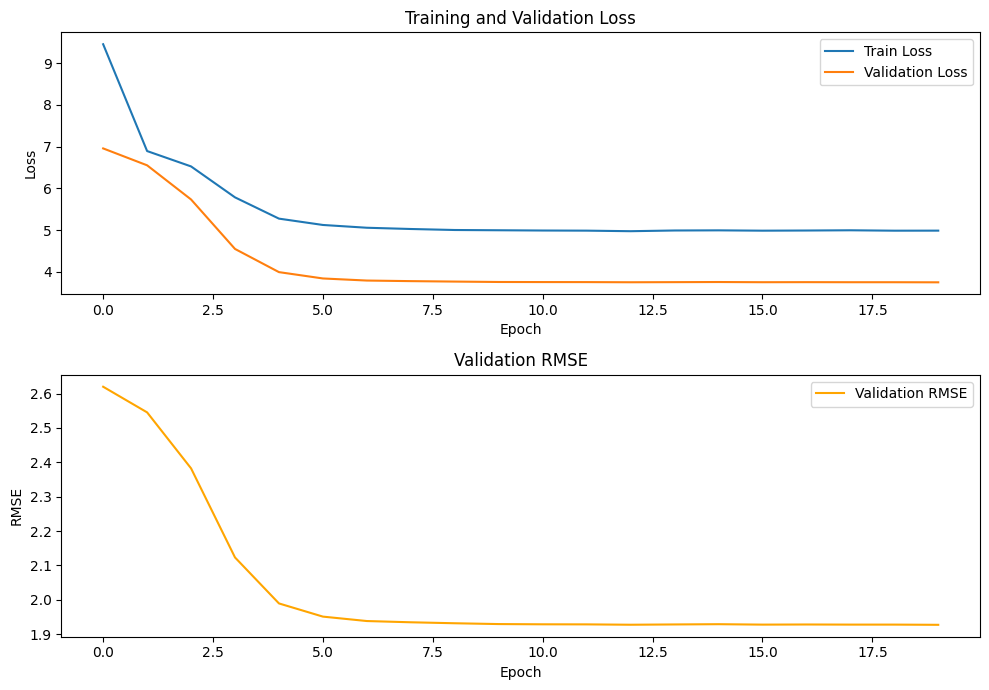

In [15]:
plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.plot(train_losses_epochs, label='Train Loss')
plt.plot(val_losses_epochs, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(val_rmses_epochs, label='Validation RMSE', color='orange')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Validation RMSE')
plt.legend()

plt.tight_layout()
plt.show()